In [1]:
import numpy as np
from numpy import pi as pi
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# parameters 
N = 180 # number of I & E neurons
xs = np.linspace(0, 180, 181) # angle positions in deg; want 0, 1, 2, ..., 180 degrees

tau_E = 20 #ms
tau_I = 10 #ms

J_EE = 0.044 
J_IE = 0.042
J_EI = 0.023
J_II = 0.018

sigma_ori = 32
sigma_FF = 30
phi = 45 # stimulus grating angle, paper uses Stimulus 1 = 45deg, Stimulus 2 = 135deg

k = 0.04
n = 2.0

c = 50 # stimulus strength

 - $G_\sigma(x,y) = \exp\{-d(x,y)^2/\sigma^2\}$, where $d(x,y)=|x-y|$ for positions, and for orientations, $d(x,y) = $ shortest distance around circle with $180^\circ$ circumference between $x$ and $y$
 - $N$ excitatory units and $N$ inhibitory units
 - Stimulus grating with orientation $\phi$ is $h(\theta) = G_{\sigma_{\text{FF}}}(\phi, \theta)$
 - Connection functions are $W_{ab} = J_{ab} G_{\sigma_{\text{ori}}}(\theta, \theta')$ for $a,b \in \{E, I\}.$
 
 We implement the Euler method for solving this system.
 
 \begin{align*}
     r_E^{m+1}(x) &= r_E^m(x) + \Delta t \frac{1}{\tau_E}\left(-r_E^m(x) + F_E^m(x) \right) \\
     r_I^{m+1}(x) &= r_I^m(x) + \Delta t \frac{1}{\tau_I}\left(-r_I^m(x) + F_I^m(x) \right)
 \end{align*}
 where 
 \begin{align*}
     F_E^m(x) &= k\left(\left[ch(x) +  \sum_{y}(J_{EE}G_{\sigma_{\text{ori}}}(x,y)r_E^m(y) + J_{EI}G_{\sigma_{\text{ori}}}(x,y)r_I^m(y)) \right]_+  \right)^n \\
     F_I^m(x) &= k\left(\left[ch(x) +  \sum_{y}(J_{IE}G_{\sigma_{\text{ori}}}(x,y)r_E^m(y) + J_{II}G_{\sigma_{\text{ori}}}(x,y)r_I^m(y)) \right]_+ \right)^n
 \end{align*}
 
 with the sums running over all orientations $y$.

The distance function

$$
    d(x,y) = \min\{|x-y|, 180-|x-y|\}
$$

is a metric on $\left[0,180\right]$ with $0\sim 180.$ But this introduces non-differentiability. So consider a softmin function

$$ 
    \tilde{d}(x,y) = -\log(\exp\{-x\} + \exp\{-y\})
$$

Also, we can define a soft absolute value by perturbing $\sqrt{x^2}$ by some small $\varepsilon^2$:

$$
    |x| \approx \sqrt{x^2 + \varepsilon^2}.
$$

A smooth distance function we might use in the Gaussian could be 

$$ 
    d(x,y) = -\log(\exp\{-\sqrt{(x-y)^2+\varepsilon^2}\} + \exp\{-(180-\sqrt{(x-y)^2+\varepsilon^2})\})
$$

In [3]:
def d(x,y):
    return -np.log(np.exp(-(((x-y)**2+(1e-20)**2)**.5))+np.exp(-(180-((x-y)**2+(1e-20)**2)**.5)))

Testing this distance function:

In [4]:
d(0, 180)

-0.0

In [5]:
d(179, 1)

2.0

In [6]:
d(35, 175)

40.0

In [7]:
def G(x, y, sigma): # Gaussian function centered at y
    return np.exp(-np.power(d(x,y), 2.) / (2 * np.power(sigma, 2.)))

def h(phi, theta, sigma_FF): # stimulus of orientation phi
    return G(phi, theta, sigma_FF)

def F(x, n_type): # activation function, depends on neuron type n_type = I, E
    if n_type=='E':
        sumlst = [J_EE*G(x,y,sigma_ori)*r_E[m,y] + J_EI*G(x,y,sigma_ori)*r_I[m,y] for y in range(N+1)] # <-- sums over y = 0, 1, 2,...,180 degrees
        ret = k*(np.max(c*h(phi,x,sigma_FF)+np.sum(sumlst), 0))**n
    elif n_type=='I':
        sumlst = [J_IE*G(x,y,sigma_ori)*r_E[m,y] + J_II*G(x,y,sigma_ori)*r_I[m,y] for y in range(N+1)]
        ret = k*(np.max(c*h(phi,x,sigma_FF)+np.sum(sumlst), 0))**n
    return ret

Setup for implementation:
 - `r_E` $= (r_E^m(x))_{\text{steps} \times N+1}$ is a (steps)$\times (N+1)$ matrix whose entry at the $m$-th row, $x$-th column corresponds to the $m$-th timestep calculuation of rate $r_E(x)$ of the E neuron at position $x$, where $x = 0, 1, \ldots, 180$ degrees
 - `r_I` is analogous
 
Loop through $m$, filling the rows of `r_E` and `r_I` according to Euler's method. By fixing a column $x$ and looking at it as a function of $m$ we see the time course of $r_E$ and $r_I$ of the neuron at position $x$.

In [15]:
steps = 150 # number of steps to calculate
dt = .01 # time change 

r_E = np.zeros((steps+1, N+1))
r_I = np.zeros((steps+1, N+1))

for m in range(steps):
    if m > 0 and ((m/steps)*100)%5==0:
        print(f'{(m/steps)*100}%')
    for x in range(1,len(xs)):
        r_E[m+1, x] = r_E[m, x] + dt*(1/tau_E)*(-r_E[m,x] + F(x, 'E'))
        r_I[m+1, x] = r_I[m, x] + dt*(1/tau_I)*(-r_I[m,x] + F(x, 'I'))

10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


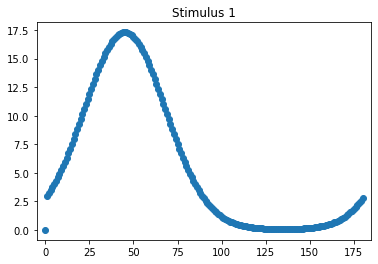

In [16]:
plt.scatter(xs, r_E[-1,:])
plt.title('Stimulus 1')
plt.xlim(-5,185)
plt.show()

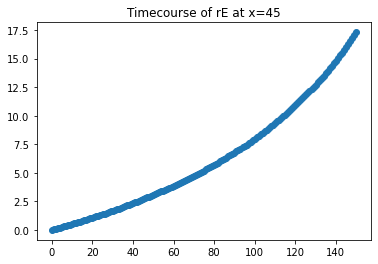

In [20]:
plt.scatter(range(steps+1), r_E[:,45])
plt.title('Timecourse of rE at x=45')
plt.show()

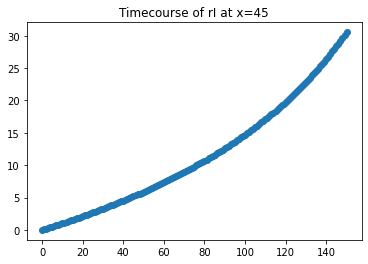

In [21]:
plt.scatter(range(steps+1), r_I[:,45])
plt.title('Timecourse of rI at x=45')
plt.show()

In [2]:
t =1 